## Covid 19 Detection using X-rays

### Part 2: Model Training & Evaluation

__Importing required packages__

In [1]:
import tensorflow as tf

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix

#Importing from tensorflow due to version issues
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Activation, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

### Model Training

__We will build three deep learning models, evaluate them and finally select any one model which gives highest performance__

__Defining the paths__

In [2]:
train_path = r'D:\Computer Vision Projects\Covid Detection from Xrays\Output\train'
test_path = r'D:\Computer Vision Projects\Covid Detection from Xrays\Output\test'

__Image Data Augmentation__

In [6]:
#We have rescaled the images by dividing the pixel values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

#To maintain uniform size of the image, we have also configured the images to shape (512,512)
train_generator = train_datagen.flow_from_directory(train_path,target_size=(512,512),color_mode='grayscale',
                                           class_mode='binary', batch_size=12)
    
test_generator = test_datagen.flow_from_directory(test_path,target_size=(512,512),color_mode='grayscale',
                                         class_mode='binary', shuffle=False, batch_size=12)

Found 1723 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


__Before creating the models, lets define a function for evaluation so that we don't have to repeat the codes.
We can call the function directly for all three models and understand the accuracy, loss, confusion matrix and classification report.__ 

In [3]:
def model_evaluation(model, model_history, test_data, num):
    epochs = [i for i in range(num)]
    fig , ax = plt.subplots(1,2)
    train_acc = model.history['accuracy']
    train_loss = model.history['loss']
    val_acc = model.history['val_accuracy']
    val_loss = model.history['val_loss']
    fig.set_size_inches(15,5)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
    ax[0].set_title('Training & Testing Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
    ax[1].set_title('Training & Testing Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Testing Loss")
    plt.show()
       
    
    #Confusion Matrix
    print('\n\n \033[1m Making Prediction with Test Data \033[0m \n')
    preds = model_history.predict(test_data, verbose = 1)
    preds[preds <= 0.5] = 0
    preds[preds > 0.5] = 1
    cm = pd.DataFrame(data=confusion_matrix(test_data.classes, preds, labels=[0,1]),
                  index=["Actual Negative", "Actual Positive"],
                  columns=["Predicted Negative", "Predicted Positive"])
    sns.heatmap(cm,annot=True,fmt="2d", cmap = "plasma")
    
    #Classification Report
    print('\n\n \033[1m Classification Report \033[0m \n')
    print(classification_report(y_true=test_data.classes, y_pred=preds, target_names =['Negative','Positive']))
    
    #Image output always comes last, so we print confusion matrix name here
    print('\n\n \033[1m Confusion Matrix \033[0m \n')

#model_evaluation(second_model, model_2, test_generator, 6)

__Deep Learning Model 1 - Custom Built Model__

In [8]:
#Initializing the model
model_1 = Sequential()
#Adding CNN 
model_1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(512,512,1)))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Conv2D(32, (3, 3), activation="relu"))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Dropout(0.3))
model_1.add(Conv2D(32, (3, 3), activation="relu"))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Conv2D(32, (3, 3), activation="relu"))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(64, (3, 3), activation="relu"))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Dropout(0.15))
model_1.add(Conv2D(64, (3, 3), activation="relu"))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Flatten())
#Adding FC Network
model_1.add(Dense(activation = 'relu', units = 128))
model_1.add(Dropout(0.3))
model_1.add(Dense(activation = 'relu', units = 64))
model_1.add(Dense(activation = 'relu', units = 32))
model_1.add(Dense(activation = 'sigmoid', units = 1))
#Compiling the model
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model_1.compile(optimizer=RMSprop(lr=0.00005), loss = 'binary_crossentropy', metrics = ['accuracy'])
#Getting model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0

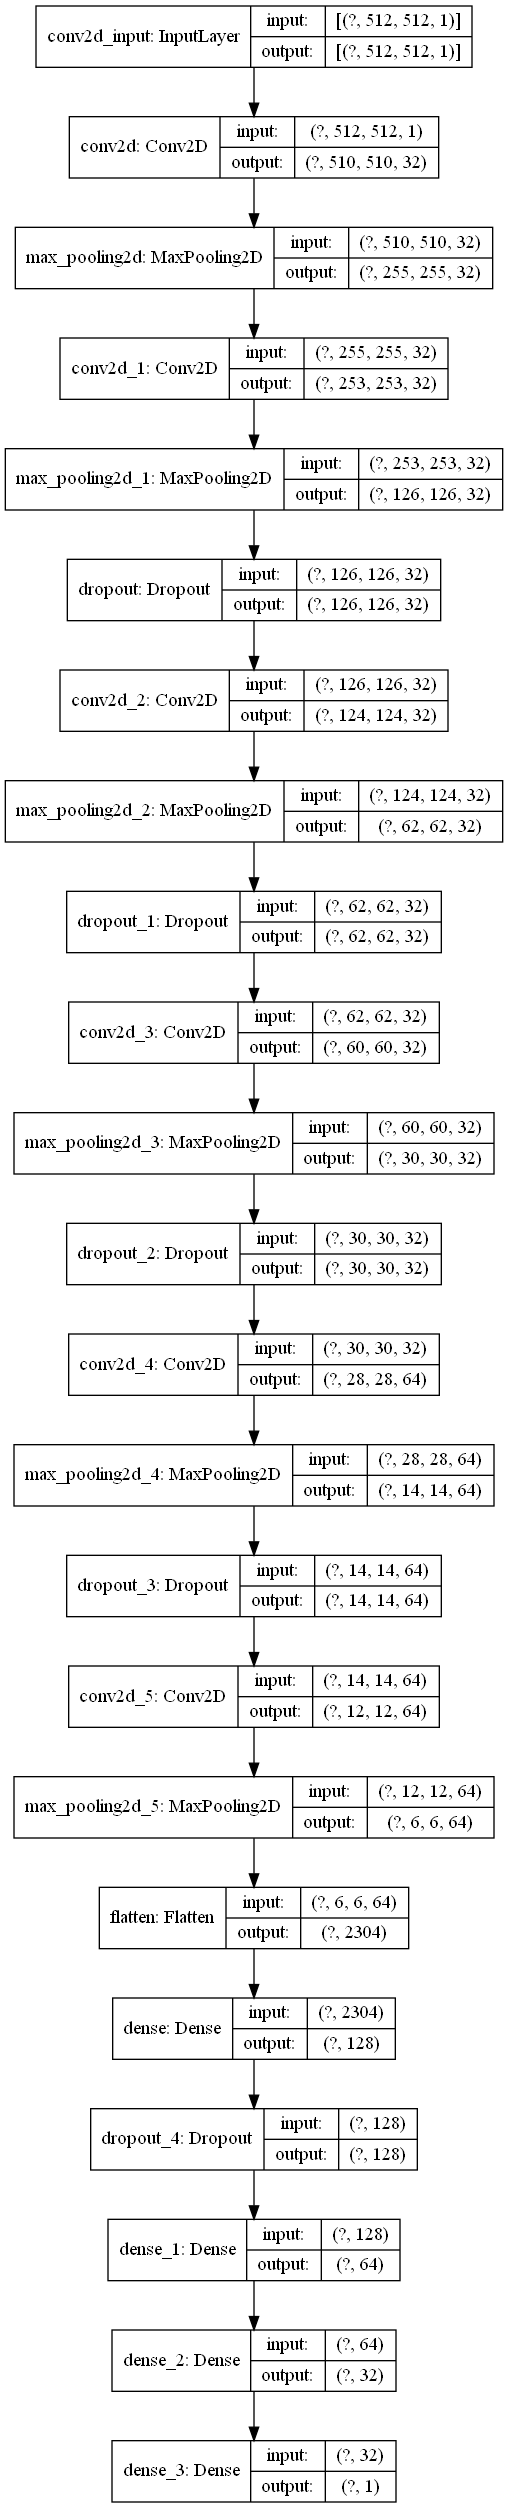

In [9]:
#Plotting the model
plot_model(model_1,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [10]:
#Computing the class weights for both classes
weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 0.6837301587301587, 1: 1.8606911447084233}


In [11]:
#Using early stopping and ReduceLROnPlateau for learning rate reduction
early = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [12]:
#Training the model
first_model = model_1.fit(train_generator, epochs=10, validation_data=test_generator, class_weight=cw, callbacks = callbacks_list)

Epoch 1/10
144/144 [==============================] - 81s 561ms/step - loss: 0.6332 - accuracy: 0.7127 - val_loss: 0.1818 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 2/10
144/144 [==============================] - 79s 552ms/step - loss: 0.2896 - accuracy: 0.9031 - val_loss: 0.1451 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 3/10
144/144 [==============================] - 78s 540ms/step - loss: 0.2144 - accuracy: 0.9263 - val_loss: 0.1052 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 4/10
144/144 [==============================] - 78s 543ms/step - loss: 0.1654 - accuracy: 0.9454 - val_loss: 0.0803 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/10
144/144 [==============================] - 79s 549ms/step - loss: 0.1427 - accuracy: 0.9541 - val_loss: 0.0898 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 6/10
144/144 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9512
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 [=========================

__Model 1 Evaluation__

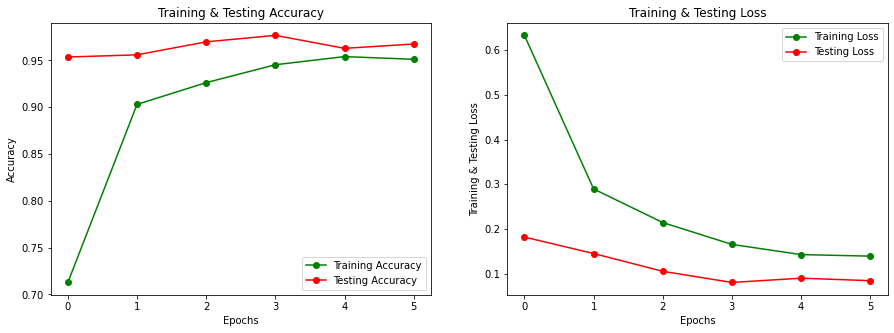



  Making Prediction with Test Data  

36/36 [==============================] - 13s 350ms/step


  Classification Report  

              precision    recall  f1-score   support

    Negative       0.98      0.97      0.98       316
    Positive       0.93      0.95      0.94       116

    accuracy                           0.97       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.97      0.97      0.97       432



  Confusion Matrix  



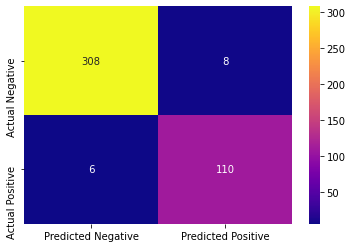

In [13]:
#Finding the epochs at which the early stopping occured
ep = 6
model_evaluation(first_model, model_1, test_generator, ep)

__Deep Learning Model 2 - Transfer Learning using InceptionV3__

__Since InceptionV3 uses three channels, we convert grayscale to RGB__

In [14]:
#To maintain uniform size of the image, we have also configured the images to shape (512,512)
train_generator = train_datagen.flow_from_directory(train_path,target_size=(512,512),color_mode='rgb',class_mode = 'binary',
                                            batch_size=5)
    
test_generator = test_datagen.flow_from_directory(test_path,target_size=(512,512),color_mode='rgb', class_mode = 'binary',
                                          shuffle=False, batch_size=5)

Found 1723 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


__Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.__

__In our case we are using the InceptionV3 model from the Keras.Applications library as the base model.__

In [15]:
base_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape= (512,512,3))
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

__Note: This is not the summary of our model and this is the summary or the architecture of the InceptionV3 model that we are deploying as the base model.__

In [16]:
#Initializing the Architecture
model_2=Sequential()
#Adding the InceptionV3 as base model
model_2.add(base_model)
#Adding the FC Network
model_2.add(Dense(256,activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(64,activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(activation = 'sigmoid', units = 1))
model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#model_2.compile(optimizer = RMSprop(lr = 0.00005), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 14, 14, 256)       524544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
dense_5 (Dense)              (None, 14, 14, 128)       32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
dense_6 (Dense)              (None, 14, 14, 64)        8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

__This is now the complete summary of our model that we shall use to classify the images.__

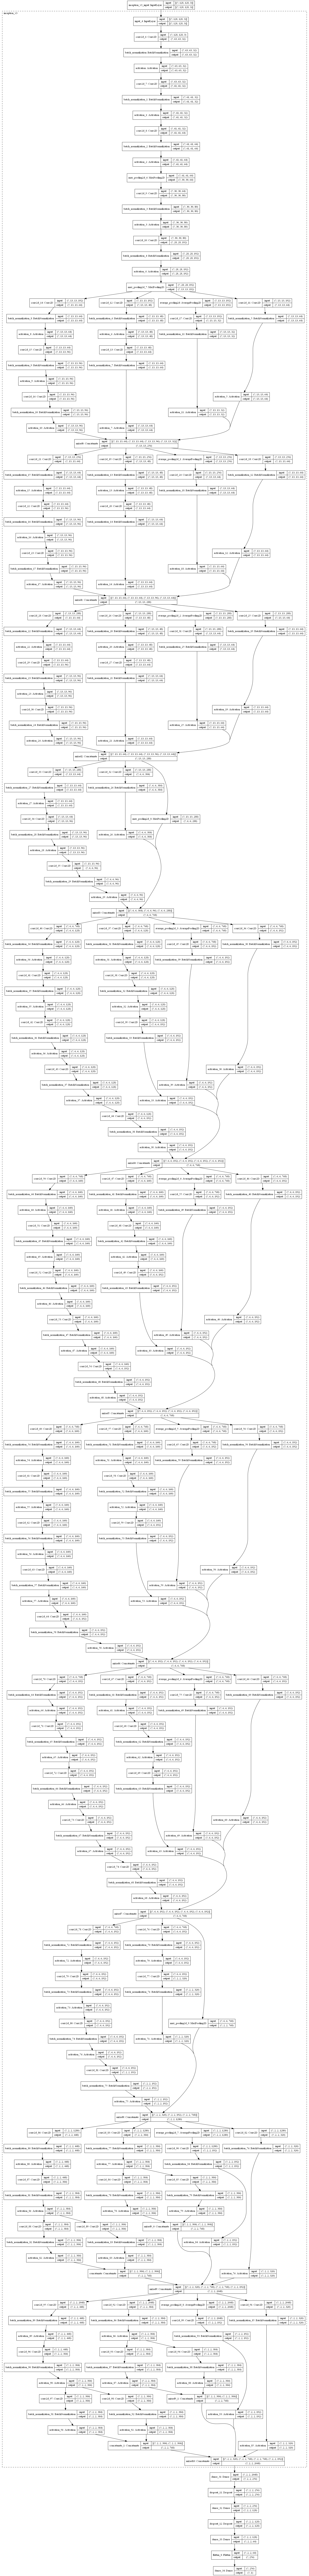

In [60]:
#Plotting the model
plot_model(model_2,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [17]:
#Setting the InceptionV3 model to be untrainable
base_model.trainable=False

early = EarlyStopping(monitor='val_accuracy', mode='min', patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)
callbacks_list = [early, learning_rate_reduction]

In [18]:
second_model = model_2.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=callbacks_list)

Epoch 1/10
345/345 [==============================] - 155s 448ms/step - loss: 0.3540 - accuracy: 0.8793 - val_loss: 17.8128 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/10
345/345 [==============================] - 141s 408ms/step - loss: 0.1880 - accuracy: 0.9402 - val_loss: 0.1109 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 3/10
345/345 [==============================] - 141s 409ms/step - loss: 0.1517 - accuracy: 0.9553 - val_loss: 0.1074 - val_accuracy: 0.9583 - lr: 0.0010


__Model 2 Evaluation__

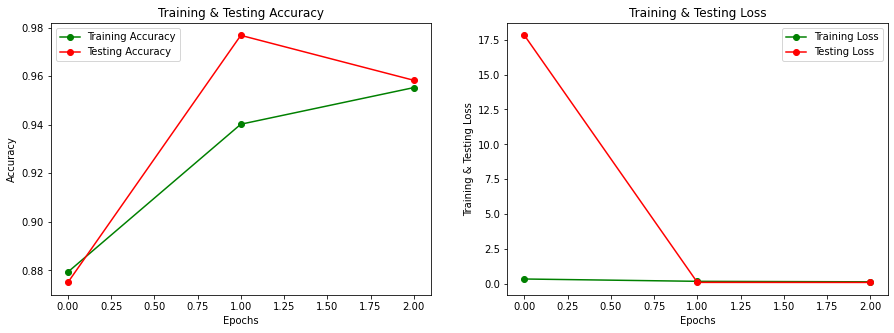



  Making Prediction with Test Data  

87/87 [==============================] - 14s 157ms/step


  Classification Report  

              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       316
    Positive       0.87      1.00      0.93       116

    accuracy                           0.96       432
   macro avg       0.93      0.97      0.95       432
weighted avg       0.96      0.96      0.96       432



  Confusion Matrix  



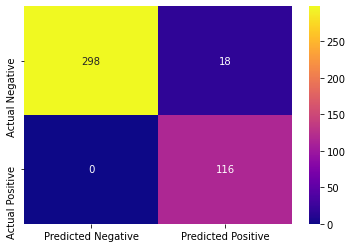

In [19]:
#Finding the epochs at which the early stopping occured
ep = 3
model_evaluation(second_model, model_2, test_generator, ep)

__Saving and reloading model in HDF5 file format__

In [21]:
model_2.save("covid_model2.h5")

In [23]:
loaded_model = load_model("covid_model.h5")
loss, accuracy = loaded_model.evaluate(test_generator)

87/87 [==============================] - 13s 154ms/step - loss: 0.1074 - accuracy: 0.9583


__Deep Learning Model 3 - Transfer Learning using VGG16__

__Since VGG16 uses three channels, we convert grayscale to RGB__

In [30]:
#To maintain uniform size of the image, we have also configured the images to shape (128,128)
train_generator = train_datagen.flow_from_directory(train_path,target_size=(128,128),color_mode='rgb',class_mode = 'binary',
                                            batch_size=5)
    
test_generator = test_datagen.flow_from_directory(test_path,target_size=(128,128),color_mode='rgb', class_mode = 'binary',
                                          shuffle=False, batch_size=5)

Found 1723 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


__We are using the VGG16 model from the Keras.Applications library as the base model.__

In [31]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(128,128,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

__Note: This is not the summary of our model and this is the summary or the architecture of the VGG16 model that we are deploying as the base model.__

__Adding our Own Fully Connected Layers__

Now we need to add at the top of the base model some fully connected layers. Also we can add the Dropout layers for increasing randomness.

For this I have used a Keras sequential model and build our entire model on top of it, comprising of the VGG model as the base model + our own fully connected layers.

In [32]:
#Initializing the Architecture
model_3=Sequential()
#Adding the VGG16 as base model
model_3.add(base_model)
#Adding the FC Network
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(Dense(128,activation='relu'))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Flatten())
model_3.add(Dense(activation = 'sigmoid', units = 1))
#model_3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_3.compile(optimizer = RMSprop(lr = 0.00005), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_12 (Dense)             (None, 4, 4, 256)         131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
dense_13 (Dense)             (None, 4, 4, 128)         32896     
_________________________________________________________________
dense_14 (Dense)             (None, 4, 4, 64)          8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)             

__This is now the complete summary of our model that we shall use to classify the images.__

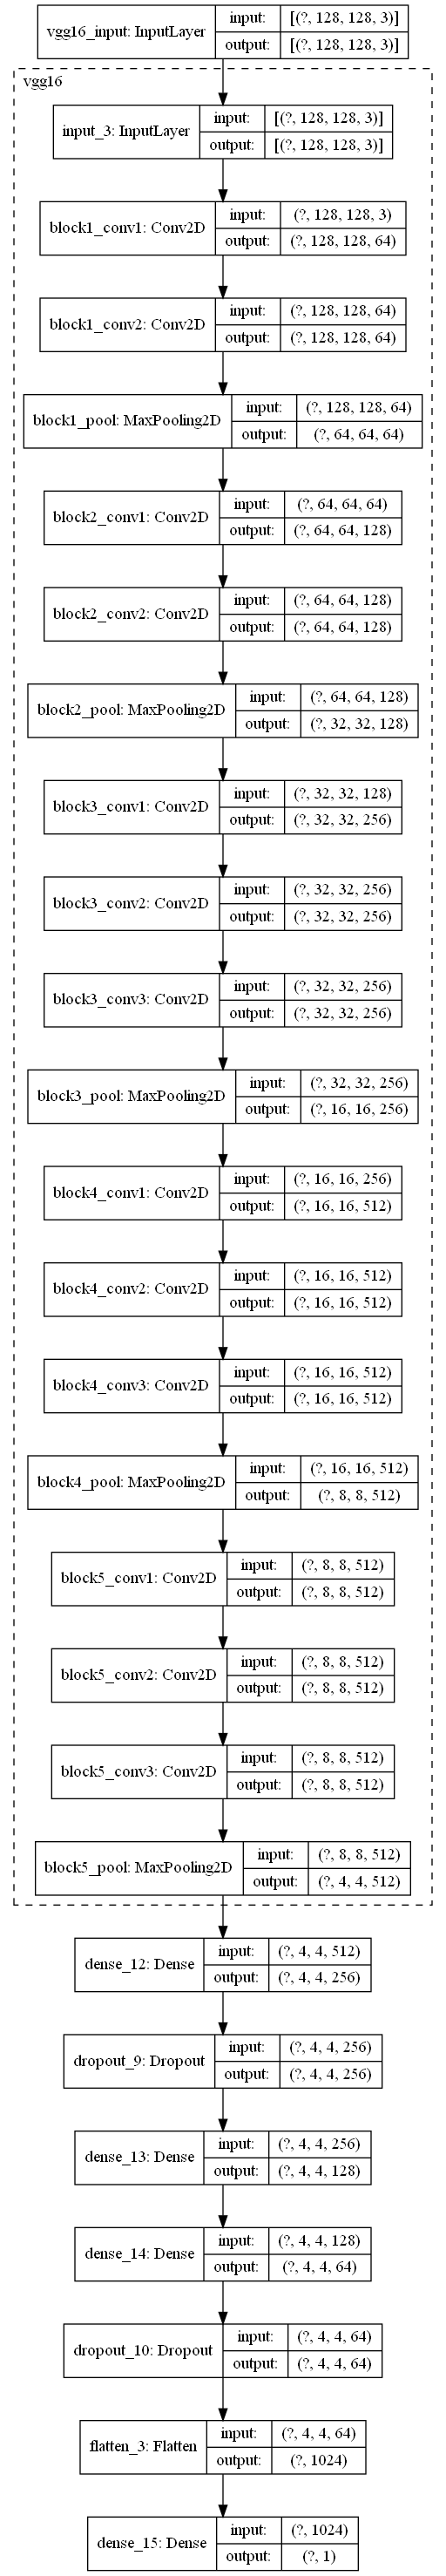

In [33]:
#Plotting the model
plot_model(model_3,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [34]:
#Setting the VGG model to be untrainable
base_model.trainable=False

early = EarlyStopping(monitor='val_accuracy', mode='min', patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [35]:
third_model = model_3.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=callbacks_list)

Epoch 1/10
345/345 [==============================] - 62s 181ms/step - loss: 0.1502 - accuracy: 0.9443 - val_loss: 0.0464 - val_accuracy: 0.9861 - lr: 5.0000e-05
Epoch 2/10
345/345 [==============================] - 60s 175ms/step - loss: 0.0954 - accuracy: 0.9791 - val_loss: 0.0151 - val_accuracy: 0.9954 - lr: 5.0000e-05
Epoch 3/10
345/345 [==============================] - 60s 175ms/step - loss: 0.0605 - accuracy: 0.9849 - val_loss: 0.0732 - val_accuracy: 0.9699 - lr: 5.0000e-05
Epoch 4/10
345/345 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9884
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
345/345 [==============================] - 61s 177ms/step - loss: 0.0641 - accuracy: 0.9884 - val_loss: 0.1349 - val_accuracy: 0.9745 - lr: 5.0000e-05
Epoch 5/10
345/345 [==============================] - 59s 170ms/step - loss: 0.0244 - accuracy: 0.9954 - val_loss: 0.0373 - val_accuracy: 0.9884 - lr: 1.5000e-05


__Model 3 Evaluation__

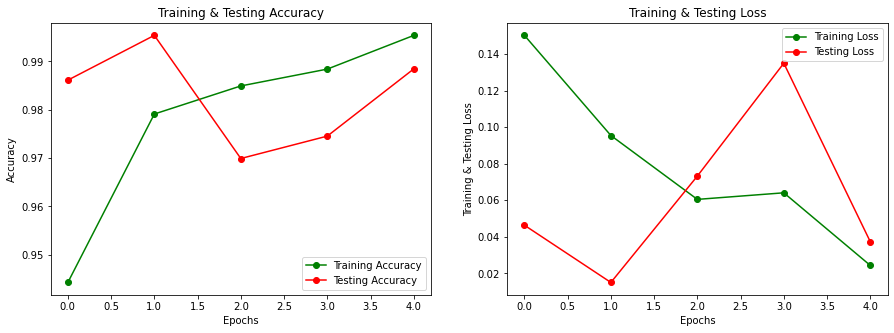



  Making Prediction with Test Data  

87/87 [==============================] - 12s 133ms/step


  Classification Report  

              precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       316
    Positive       1.00      0.96      0.98       116

    accuracy                           0.99       432
   macro avg       0.99      0.98      0.99       432
weighted avg       0.99      0.99      0.99       432



  Confusion Matrix  



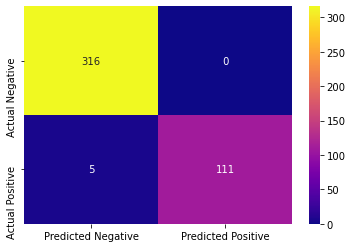

In [36]:
#Finding the epochs at which the early stopping occured
ep = 5
model_evaluation(third_model, model_3, test_generator, ep)

In [37]:
loss, accuracy = model_3.evaluate(test_generator)

87/87 [==============================] - 12s 132ms/step - loss: 0.0373 - accuracy: 0.9884


__Due to size constraints, we will create a simple convolutional neural network only for the purpose of deployment__

In [16]:
#We have rescaled the images by dividing the pixel values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

#To maintain uniform size of the image, we have also configured the images to shape (75,75)
train_generator = train_datagen.flow_from_directory(train_path,target_size=(75,75),color_mode='grayscale',
                                           class_mode='binary', batch_size=15)
    
test_generator = test_datagen.flow_from_directory(test_path,target_size=(75,75),color_mode='grayscale',
                                         class_mode='binary', shuffle=False, batch_size=15)

Found 1723 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


In [17]:
#Initializing the model
model_4 = Sequential()
#Adding CNN 
model_4.add(Conv2D(32, (3, 3), activation="relu", input_shape=(75,75,1)))
model_4.add(MaxPooling2D(pool_size = (2, 2)))
model_4.add(Conv2D(32, (3, 3), activation="relu"))
model_4.add(MaxPooling2D(pool_size = (2, 2)))
model_4.add(Dropout(0.3))
model_4.add(Flatten())
#Adding the FC Network
model_4.add(Dense(activation = 'relu', units = 128))
model_4.add(Dense(activation = 'sigmoid', units = 1))
model_4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#model_2.compile(optimizer = RMSprop(lr = 0.00005), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 73, 73, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9248)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [18]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [19]:
deploy_model = model_4.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=callbacks_list)

Epoch 1/10
115/115 [==============================] - 59s 513ms/step - loss: 0.2741 - accuracy: 0.8845 - val_loss: 0.1173 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/10
115/115 [==============================] - 59s 512ms/step - loss: 0.1169 - accuracy: 0.9600 - val_loss: 0.0798 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 3/10
115/115 [==============================] - 66s 576ms/step - loss: 0.1019 - accuracy: 0.9634 - val_loss: 0.0698 - val_accuracy: 0.9792 - lr: 0.0010


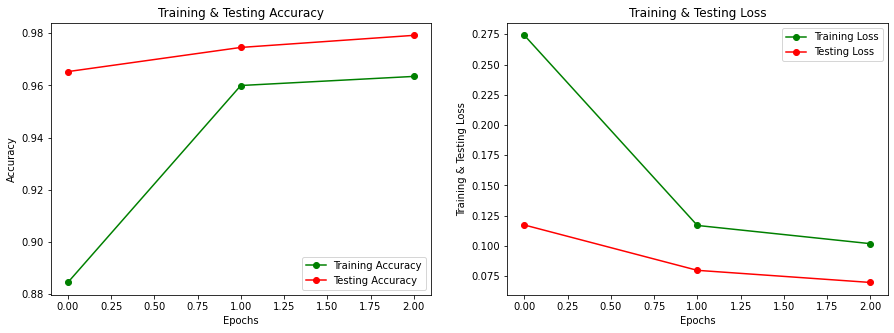



  Making Prediction with Test Data  

29/29 [==============================] - 13s 446ms/step


  Classification Report  

              precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       316
    Positive       0.99      0.93      0.96       116

    accuracy                           0.98       432
   macro avg       0.98      0.96      0.97       432
weighted avg       0.98      0.98      0.98       432



  Confusion Matrix  



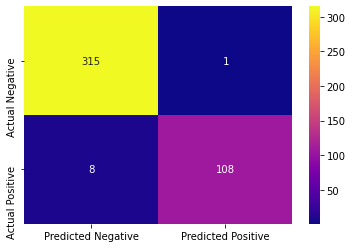

In [20]:
#Finding the epochs at which the early stopping occured
ep = 3
model_evaluation(deploy_model, model_4, test_generator, ep)

In [21]:
model_4.save("covid_model.h5")